In [38]:
import requests
import json
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import csv
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [39]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ademt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ademt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ademt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
## 2. openFDA Verisini Çekme
#openFDA API'sinden yan etki açıklamalarını ve ilaç isimlerini çekiyoruz. Yaklaşık 5.000 kayıt alacağız.

In [41]:
def fetch_openfda_data(limit=5000):
    url = "https://api.fda.gov/drug/event.json"
    params = {
        "limit": 100,  # API tek seferde max 100 kayıt döndürüyor, döngüyle 5.000'e ulaşacağız
        "skip": 0
    }
    data = []
    while len(data) < limit:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            results = response.json().get("results", [])
            for result in results:
                reactions = result.get("patient", {}).get("reaction", [])
                drugs = result.get("patient", {}).get("drug", [])
                for reaction in reactions:
                    reaction_text = reaction.get("reactionmeddrapt", "")
                    for drug in drugs:
                        drug_name = drug.get("medicinalproduct", "")
                        if reaction_text and drug_name:
                            data.append({"reaction": reaction_text, "drug": drug_name})
            params["skip"] += 100
        else:
            print(f"Hata: {response.status_code}")
            break
        if len(results) < 100:  # Son sayfa
            break
    return data[:limit]

In [42]:
# Veriyi çek
data = fetch_openfda_data(5000)
print(f"Toplam {len(data)} kayıt çekildi.")

Toplam 5000 kayıt çekildi.


In [43]:
# Örnek veri
data[:5]

[{'reaction': 'DRUG ADMINISTRATION ERROR', 'drug': 'DURAGESIC-100'},
 {'reaction': 'OVERDOSE', 'drug': 'DURAGESIC-100'},
 {'reaction': 'Vomiting', 'drug': 'BONIVA'},
 {'reaction': 'Diarrhoea', 'drug': 'BONIVA'},
 {'reaction': 'Arthralgia', 'drug': 'BONIVA'}]

In [44]:
## 3. Veriyi İşleme
#Veriyi cümlelere ayırıyoruz ve sadece yan etki açıklamalarını kullanıyoruz.

In [47]:
# Yan etki açıklamalarını al
texts = [entry["reaction"] for entry in data]

In [48]:
# Cümlelere ayırma
sentences = []
for text in texts:
    sentences.extend(sent_tokenize(text))
    print(f"Toplam {len(sentences)} cümle ayrıldı.")
sentences[:10]

Toplam 1 cümle ayrıldı.
Toplam 2 cümle ayrıldı.
Toplam 3 cümle ayrıldı.
Toplam 4 cümle ayrıldı.
Toplam 5 cümle ayrıldı.
Toplam 6 cümle ayrıldı.
Toplam 7 cümle ayrıldı.
Toplam 8 cümle ayrıldı.
Toplam 9 cümle ayrıldı.
Toplam 10 cümle ayrıldı.
Toplam 11 cümle ayrıldı.
Toplam 12 cümle ayrıldı.
Toplam 13 cümle ayrıldı.
Toplam 14 cümle ayrıldı.
Toplam 15 cümle ayrıldı.
Toplam 16 cümle ayrıldı.
Toplam 17 cümle ayrıldı.
Toplam 18 cümle ayrıldı.
Toplam 19 cümle ayrıldı.
Toplam 20 cümle ayrıldı.
Toplam 21 cümle ayrıldı.
Toplam 22 cümle ayrıldı.
Toplam 23 cümle ayrıldı.
Toplam 24 cümle ayrıldı.
Toplam 25 cümle ayrıldı.
Toplam 26 cümle ayrıldı.
Toplam 27 cümle ayrıldı.
Toplam 28 cümle ayrıldı.
Toplam 29 cümle ayrıldı.
Toplam 30 cümle ayrıldı.
Toplam 31 cümle ayrıldı.
Toplam 32 cümle ayrıldı.
Toplam 33 cümle ayrıldı.
Toplam 34 cümle ayrıldı.
Toplam 35 cümle ayrıldı.
Toplam 36 cümle ayrıldı.
Toplam 37 cümle ayrıldı.
Toplam 38 cümle ayrıldı.
Toplam 39 cümle ayrıldı.
Toplam 40 cümle ayrıldı.
Toplam 41

['DRUG ADMINISTRATION ERROR',
 'OVERDOSE',
 'Vomiting',
 'Diarrhoea',
 'Arthralgia',
 'Headache',
 'Dyspepsia',
 'Renal impairment',
 'Drug ineffective',
 'Drug hypersensitivity']

In [49]:
## 4. Stopwords Listesi
#İngilizce stopwords listesini yüklüyoruz.

In [50]:
stop_words = set(stopwords.words('english'))
stop_words_list = list(stop_words)
print(stop_words_list[:50])

['haven', 'she', 'out', "it'll", 'their', 'or', 'those', 'did', 'shan', 'where', 'has', 'such', "couldn't", 'too', 'why', 'this', 's', 'who', 'y', 'is', 'needn', 'o', 'should', 'isn', 'very', "we're", 'some', 'it', 'most', 'then', 'once', 'll', 'nor', 'but', 'few', "it's", 'mightn', 'other', 'of', "they've", "won't", 'hasn', "i'll", 'to', 'here', 'myself', 'ain', 'your', 'just', 'both']


In [51]:
## 5. Lemmatizer ve Stemmer Başlatma
#Kelimeleri normalize etmek için lemmatizer ve stemmer kullanıyoruz

In [52]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [53]:
## 6. Cümleleri Ön İşleme
#Her cümleyi tokenleştiriyor, stopwords’leri kaldırıyor, lemmatize ve stem ediyoruz.

In [54]:
def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence)
    # Sadece harflerden oluşan kelimeleri al, küçük harfe çevir ve stopwords'leri kaldır
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    # Lemmatizasyon
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return lemmatized_tokens, stemmed_tokens

In [55]:
# Tüm cümleleri işleme
tokenized_corpus_lemmatized = []
tokenized_corpus_stemmed = []

for sentence in sentences:
    lemmatized_tokens, stemmed_tokens = preprocess_sentence(sentence)
    tokenized_corpus_lemmatized.append(lemmatized_tokens)
    tokenized_corpus_stemmed.append(stemmed_tokens)

print(f"İşlenen cümle sayısı: {len(tokenized_corpus_lemmatized)}")

İşlenen cümle sayısı: 5000


In [56]:
## 7. Lemmatize Edilmiş Cümleleri CSV'ye Kaydetme

In [57]:
with open("lemmatized_sentences.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for tokens in tokenized_corpus_lemmatized:
        writer.writerow([' '.join(tokens)])
print("Lemmatize edilmiş cümleler 'lemmatized_sentences.csv' dosyasına kaydedildi.")

Lemmatize edilmiş cümleler 'lemmatized_sentences.csv' dosyasına kaydedildi.


In [58]:
## 8. Stem Edilmiş Cümleleri CSV'ye Kaydetme

In [59]:
with open("stemmed_sentences.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for tokens in tokenized_corpus_stemmed:
        writer.writerow([' '.join(tokens)])
print("Stem edilmiş cümleler 'stemmed_sentences.csv' dosyasına kaydedildi.")

Stem edilmiş cümleler 'stemmed_sentences.csv' dosyasına kaydedildi.


In [60]:
## 9. İlk 5 Cümlenin Karşılaştırması
#Orijinal, lemmatize edilmiş ve stem edilmiş hallerini yazdırıyoruz

In [61]:
for i in range(min(5, len(sentences))):
    print(f"Cümle {i+1} - Orijinal: {sentences[i]}")
    print(f"Cümle {i+1} - Lemmatized: {tokenized_corpus_lemmatized[i]}")
    print(f"Cümle {i+1} - Stemmed: {tokenized_corpus_stemmed[i]}")
    print()

Cümle 1 - Orijinal: DRUG ADMINISTRATION ERROR
Cümle 1 - Lemmatized: ['drug', 'administration', 'error']
Cümle 1 - Stemmed: ['drug', 'administr', 'error']

Cümle 2 - Orijinal: OVERDOSE
Cümle 2 - Lemmatized: ['overdose']
Cümle 2 - Stemmed: ['overdos']

Cümle 3 - Orijinal: Vomiting
Cümle 3 - Lemmatized: ['vomiting']
Cümle 3 - Stemmed: ['vomit']

Cümle 4 - Orijinal: Diarrhoea
Cümle 4 - Lemmatized: ['diarrhoea']
Cümle 4 - Stemmed: ['diarrhoea']

Cümle 5 - Orijinal: Arthralgia
Cümle 5 - Lemmatized: ['arthralgia']
Cümle 5 - Stemmed: ['arthralgia']



In [62]:
## 10. Kelime Bulutu Görselleştirme
#Temizlenmiş corpus için bir kelime bulutu oluşturuyoruz

In [63]:
# Tüm lemmatize edilmiş kelimeleri birleştir
all_lemmatized_words = ' '.join([' '.join(tokens) for tokens in tokenized_corpus_lemmatized])

In [64]:
# Kelime bulutu oluştur
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lemmatized_words)

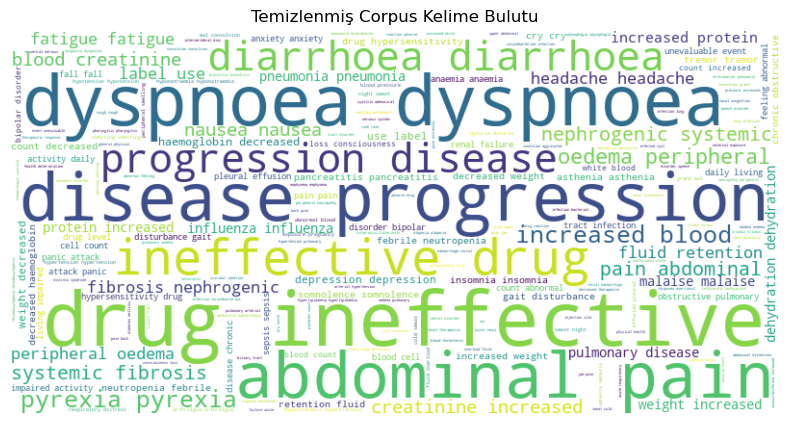

In [65]:
# Görselleştir
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Temizlenmiş Corpus Kelime Bulutu')
plt.show()